# DSML Team Assignment: Milestone 1 – Group 4  
**_Predicting Traffic Volume from Ride-Hailing Trips in Chicago_**

*By Louis, Malak, Lena, and Eero*


---

## Dataset

**Transportation Network Providers - Trips (2023–2024):**
https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips-2023-2024-/n26f-ihde/explore/query/SELECT%0A%20%20%60trip_id%60%2C%0A%20%20%60trip_start_timestamp%60%2C%0A%20%20%60trip_end_timestamp%60%2C%0A%20%20%60trip_seconds%60%2C%0A%20%20%60trip_miles%60%2C%0A%20%20%60percent_time_chicago%60%2C%0A%20%20%60percent_distance_chicago%60%2C%0A%20%20%60pickup_census_tract%60%2C%0A%20%20%60dropoff_census_tract%60%2C%0A%20%20%60pickup_community_area%60%2C%0A%20%20%60dropoff_community_area%60%2C%0A%20%20%60fare%60%2C%0A%20%20%60tip%60%2C%0A%20%20%60additional_charges%60%2C%0A%20%20%60trip_total%60%2C%0A%20%20%60shared_trip_authorized%60%2C%0A%20%20%60shared_trip_match%60%2C%0A%20%20%60trips_pooled%60%2C%0A%20%20%60pickup_centroid_latitude%60%2C%0A%20%20%60pickup_centroid_longitude%60%2C%0A%20%20%60pickup_centroid_location%60%2C%0A%20%20%60dropoff_centroid_latitude%60%2C%0A%20%20%60dropoff_centroid_longitude%60%2C%0A%20%20%60dropoff_centroid_location%60%0AORDER%20BY%20%60trip_start_timestamp%60%20DESC%20NULL%20FIRST/page/filter

## 🎯 Prediction Task

We aim to predict **traffic volume** based on individual ride-hailing trips in Chicago, US.

Our first approach is deriving this by dividing *trip seconds* by *trip miles*, representing the average duration per mile (higher values indicate greater congestion), thus indicating traffic volume/ defining a proxy for traffic volume.

> `traffic_volume_proxy = trip_seconds / trip_miles`

We plan on including the following **features**:
- hour (extrcating from `trip_start_timestamp`)
- day of the week (from `trip_start_timestamp`)
- `pickup_community_area`
- `dropoff_community_area`
- `trip_seconds`
- `trip_miles`
- `trip_total` (excluding tips)
- weather data (optional, using another database)

---

## Business Understanding

 Ride-hailing services use mobile apps such as Uber or Lyft to connect passengers to drivers, with the goal of providing fast and cost-effective transportation for users. Furthermore, reducing traffic congestion, lowering emissions, and increasing vehicle utilization are key incentives.

In Chicago, transit via bus and rail is on the rise. In 2023, there was a total of 279.1 million rides, marking a 13% increase from 2022. Ride-hailing services have also seen increased adoption, especially in downtown areas. Fees for solo rides have even been implemented in the downtown area during peak times to encourage shared rides.

Chicago remains one of the most congested US cities, especially during peak hours. Thus, the city is actively promoting shared mobility options, providing, for example, Divvy Bikes — a city-owned system for renting both bikes and scooters.

## Data Understanding

The given dataset provides us with a total of 1,743,696 individual trips, including various features. Below, we will go over each one and evaluate whether the feature will be useful for our prediction task, if we will only include data with a set value, or if it should be excluded during our data preparation.

- **Trip ID**: Will be included as our primary key.

- **Trip Start Time** & **Trip End Time**: Useful to our prediction task. Time is an important factor for traffic volume, which spikes during peak hours.

- **Trip Seconds** & **Trip Miles**: Useful to our prediction task. Both are essential to our calculation of traffic volume.

- **Percent Time Chicago** & **Percent Distance Chicago**: Only trips with 100% will be included. Trips with routes outside of Chicago do not fit our prediction task of modeling traffic volume *in Chicago*.

- **Pickup Census Tract** & **Dropoff Census Tract**: Will be excluded. Compared to Pickup Community Area and Dropoff Community Area — which represent 77 large zones in Chicago — Census Tract identifies over 800 smaller zones. While more specific, they run a higher risk of missing data and reduce the likelihood of trips being comparable to each other.

- **Pickup Community Area** & **Dropoff Community Area**: Useful for our prediction task. Traffic volume varies by location, and these provide a robust feature for space.

- **Fare, Tip, Additional Charges, and Trip Total**: We will use trip total excluding tips, as this serves as an indicator of traffic congestion due to dynamic pricing used by apps such as Uber or Lyft. Only data with no tips will be used, as tipping is subjective and influenced by user generosity, culture, and driver service quality.

- **Shared Trips Authorized, Shared Trips Match, and Trips Pooled**: Only data from trips that were not shared will be used, as trips stopping for other passengers would impact trip seconds without being a clear indication of traffic volume.

- **Latitude, Longitude, and Location Coordinates**: Will be excluded for the same reasons as Census Tract — too specific and less useful for comparison for the prediction task.

---

## Data Preparation

We filtered the raw data according to our data requirements stated above via the Chicago Data Portal and ended up with 32,752,518 individual trips.

To reduce the data while preserving trips from different timeframes throughout 2023–2024, we initially considered to apply another filter base on the Trip ID — for example, including every trip containing "197." After discussion, we concluded this approach could introduce bias. We decided on downloading all rows and afterwards reducing the data to every 100th entry via a Python script. The script was written by ChatGPT.

We now have 327,526 individual trips to work with, fulfilling the condition of at least 100,000 rows in the raw data. With 77 different area codes — each for pickup and dropoff — this results in an average of approximately 55 identical trips per unique pickup–dropoff area code combination.

After exporting, we will clean the data before moving on to modeling.

In [3]:
import pandas as pd

rds = pd.read_csv("Ridehailing_Chicago_sample327k.csv")

We want to check if the following filters were applied accordingly:

- 100% of the trip was driven in Chicago
- No tip
- No shared driving

In [4]:
rds['percent_time_chicago'] = rds['percent_time_chicago'].astype(str)
rds['percent_distance_chicago'] = rds['percent_distance_chicago'].astype(str)

all_conditions_met = (
    (rds['shared_trip_match'] == False) &
    (rds['shared_trip_authorized'] == False) &
    (rds['tip'] == 0) &
    (rds['percent_time_chicago'] == '1') &
    (rds['percent_distance_chicago'] == '1')
)

print("All rows match filters:", all_conditions_met.all())

All rows match filters: True


In [ ]:
import pandas as pd
import requests
import time
from io import StringIO

# API-URL und Filter
base_url = "https://data.cityofchicago.org/resource/n26f-ihde.csv"
params_base = {
    "$where": "percent_time_chicago = 1 AND percent_distance_chicago = 1 AND tip = 0 AND shared_trip_authorized = false AND shared_trip_match = false",
    "$limit": 1000000
}

dfs = []
num_blocks = 34

for i in range(num_blocks):
    offset = i * 1_000_000
    params = params_base.copy()
    params["$offset"] = offset
    print(f"[{i+1}/{num_blocks}] Lade Daten ab Offset {offset:,} ...")

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        
        # Inhalt prüfen
        if len(response.text.strip()) == 0:
            print(f"⚠️  Keine Daten empfangen bei Block {i+1}.")
            break
        
        chunk = pd.read_csv(StringIO(response.text))
        dfs.append(chunk)
        print(f"✅ {len(chunk):,} Zeilen geladen.")
        time.sleep(1)

    except Exception as e:
        print(f"❌ Fehler bei Block {i+1}: {e}")
        print("Inhalt der Antwort:")
        print(response.text[:1000])  # Nur die ersten 1000 Zeichen zeigen
        break

# Nur fortfahren, wenn Daten vorhanden
if dfs:
    print("🔄 Zusammenführen der Blöcke ...")
    full_df = pd.concat(dfs, ignore_index=True)

    print("🔃 Sortiere nach trip_start_timestamp ...")
    full_df['trip_start_timestamp'] = pd.to_datetime(full_df['trip_start_timestamp'], errors='coerce')
    full_df = full_df.dropna(subset=['trip_start_timestamp'])
    full_df = full_df.sort_values(by='trip_start_timestamp')

    print("📊 Ziehe jede 100. Zeile ...")
    sample_df = full_df.iloc[::100]

    print(f"💾 Speichere Datei mit {len(sample_df):,} Zeilen ...")
    sample_df.to_csv("Ridehailing_Chicago_sample327k.csv", index=False)
    print("✅ Fertig!")
else:
    print("❌ Keine Daten zum Verarbeiten.")


Nice!

---

## Data Exploration

After Business Understanding and Data Understanding and Preparation and before modeling or visualizing, we start by exploring key aspects of the dataset to understand patterns and context, e.g. …

- At what hour do most trips start?
- On which day of the week are most trips taken?
- What is the average traffic volume across all trips?


In [ ]:
df = pd.read_csv("Ridehailing_Chicago_sample327k.csv")

# Compute traffic volume
df = df[(df['trip_miles'] > 0) & (df['trip_seconds'] > 0)]
df['traffic_volume'] = df['trip_seconds'] / df['trip_miles']

# Convert the trip start times into datetime format
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'], errors='coerce')
df['hour'] = df['trip_start_timestamp'].dt.hour
df['day_of_week'] = df['trip_start_timestamp'].dt.dayofweek

# 1. Hour with most trips
hour_counts = df['hour'].value_counts().sort_index()
peak_hour = hour_counts.idxmax()
print(f"🔸 Most trips start at {peak_hour}:00 with {hour_counts[peak_hour]:,} trips.")

# 2. Day with most trips
day_counts = df['day_of_week'].value_counts().sort_index()
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
peak_day_index = day_counts.idxmax()
print(f"🔸 Most trips happen on {day_names[peak_day_index]} with {day_counts[peak_day_index]:,} trips.")

# 3. Average traffic volume
avg_traffic = df['traffic_volume'].mean()
print(f"🔸 The average traffic volume is {avg_traffic:.2f} seconds per mile.")

---

## Data Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Load data
df = pd.read_csv("Ridehailing_Chicago_sample327k.csv")

# Create target
df = df[(df['trip_miles'] > 0) & (df['trip_seconds'] > 0)]
df['traffic_volume'] = df['trip_seconds'] / df['trip_miles']

### Trip Volume by Hour and Weekday

First, let us try to look at how the trip volume changes over the course of an average day and week

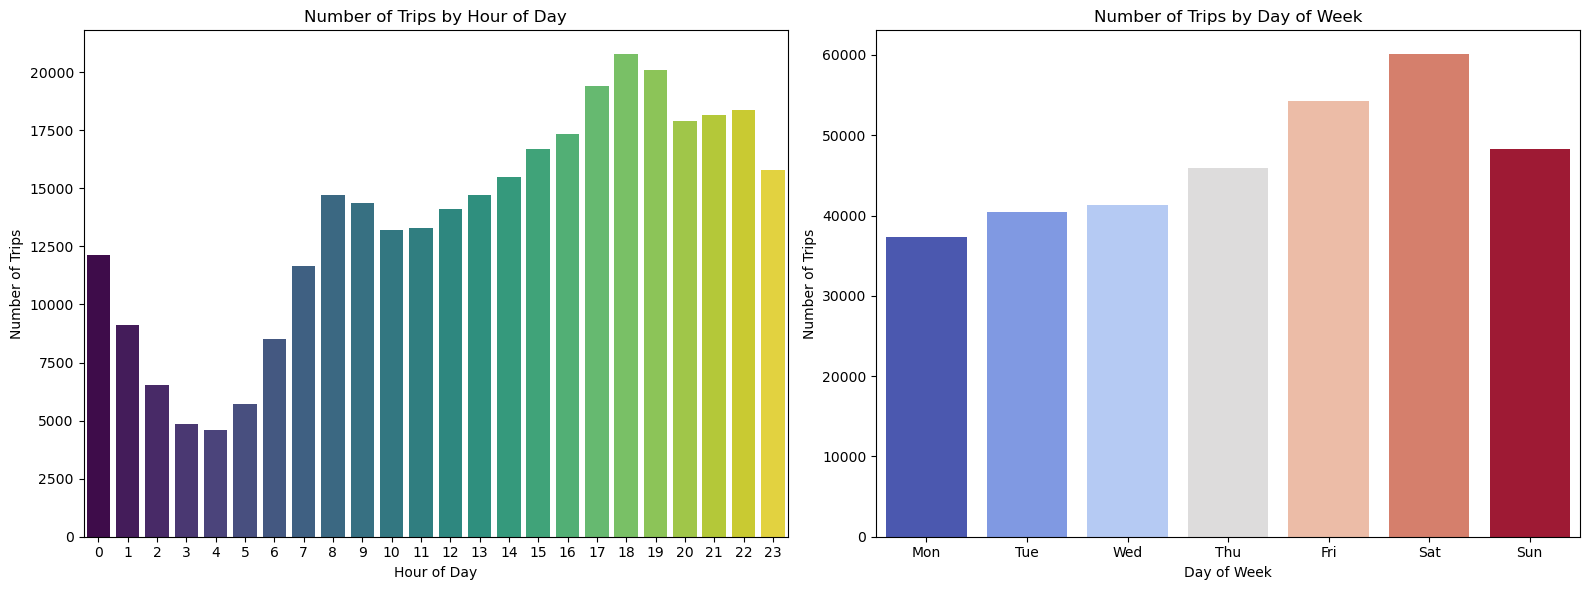

In [ ]:
# Transform trip start times into datetime format
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'], errors='coerce')
df['hour'] = df['trip_start_timestamp'].dt.hour
df['day_of_week'] = df['trip_start_timestamp'].dt.dayofweek
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Trips by Hour
sns.countplot(ax=axes[0], x='hour', data=df, hue='hour', palette='viridis', legend=False)
axes[0].set_title('Number of Trips by Hour of Day')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Number of Trips')

# Plot 2: Trips by Day of Week
sns.countplot(ax=axes[1], x='day_of_week', data=df, hue='day_of_week', palette='coolwarm', legend=False)
axes[1].set_title('Number of Trips by Day of Week')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Number of Trips')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(day_names)

plt.tight_layout()
plt.show()